# Random Forest Model - Hiperparameters Tuning

Input: testing different number of months in input using single PCA

Output: optimal max-shape portfolio with tight restrictions for the next period

## Data Pre-processing

In [1]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from helper_functions import calculate_returns_for_model,  daily_to_annual_returns

In [2]:
import os
os.chdir(os.path.expanduser('../data'))

from dotenv import load_dotenv
load_dotenv()

from DataProvider import DataProvider

In [3]:
data_provider = DataProvider()
y = data_provider.get_formatted_targets()

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


## Cross validation to calculate optimal number of months

In [4]:
df_countries, _ = data_provider.get_etf_data()
days_to_recalculate = data_provider.get_days_to_recalculate()

val_split = int(0.7 * y.shape[0])
test_split = int(0.8 * y.shape[0])
dates_for_validation = days_to_recalculate[val_split:test_split]

df_prices_val = df_countries[dates_for_validation[0]:]
df_returns_val = np.log(df_prices_val).diff().fillna(0)

In [5]:
max_sharpe = 0
best_month_no = 0

for no_months in range(3, 10):
    print(f'Random Forest Model for {no_months} months')
    x = data_provider.get_formatted_features(no_months=no_months, flatten=True)
    x_train, y_train, x_val, y_val, x_test, y_test = data_provider.train_train_split(x, y)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    skf.get_n_splits(x_train, y_train)

    sum_sharpe = 0
    for _, (train_index, _) in enumerate(skf.split(x_train, np.zeros(y_train.shape[0]))):
        x_train_fold = x_train[train_index]
        y_train_fold = y_train[train_index]

        model = RandomForestRegressor(n_estimators=50, random_state=42)
        model.fit(x_train_fold, y_train_fold)

        total_ret_val, _ = calculate_returns_for_model(
            model, x_val, dates_for_validation, df_returns_val)

        annual_returns = daily_to_annual_returns(total_ret_val)
        annual_volatility = total_ret_val.std()*np.sqrt(252)
        annual_sharpe_val = annual_returns/annual_volatility
        sum_sharpe += annual_sharpe_val
        print('Sharpe fold', annual_sharpe_val)

    mean_sharpe_val = sum_sharpe/5
    print('Mean Sharpe', mean_sharpe_val)
    if mean_sharpe_val > max_sharpe:
        max_sharpe = mean_sharpe_val
        best_month_no = no_months

print('Best number of months', best_month_no, 'with mean Sharpe ratio', max_sharpe)

Random Forest Model for 3 months
Sharpe fold 0.3998809819512934
Sharpe fold 0.404749425536925
Sharpe fold 0.38867686840371596
Sharpe fold 0.37691780084447607
Sharpe fold 0.3899592331880468
Mean Sharpe 0.39203686198489146
Random Forest Model for 4 months
Sharpe fold 0.392183794742217
Sharpe fold 0.4049378842663923
Sharpe fold 0.40418699912490336
Sharpe fold 0.40473083092029993
Sharpe fold 0.390125925682261
Mean Sharpe 0.39923308694721477
Random Forest Model for 5 months
Sharpe fold 0.39567210523759094
Sharpe fold 0.400032839262861
Sharpe fold 0.3937259691008228
Sharpe fold 0.3998028936592861
Sharpe fold 0.3998371501297947
Mean Sharpe 0.3978141914780712
Random Forest Model for 6 months
Sharpe fold 0.4018418335515332
Sharpe fold 0.40619783577840207
Sharpe fold 0.3988337263614495
Sharpe fold 0.40314840241279515
Sharpe fold 0.39438299696540213
Mean Sharpe 0.40088095901391635
Random Forest Model for 7 months
Sharpe fold 0.40645693996025334
Sharpe fold 0.418237438782664
Sharpe fold 0.41976613

In [6]:
x = data_provider.get_formatted_features(no_months=best_month_no, flatten=True)
x_train, y_train, _, _, x_test, y_test = data_provider.train_train_split(x, y, with_val=False)

## Hiperparameters Tuning

In [7]:
params = {
    "n_estimators": [10, 25, 50, 75, 100, 150],
    "max_features": ["auto", "sqrt", "log2"],
    "max_depth": [5, 10, 20, 50],
    "min_samples_split": [2, 4, 6],
    "min_samples_leaf": [2, 4, 6],
    "bootstrap": [True, False],
}

model_rf = RandomForestRegressor(random_state=42)

rf_randomsearch = RandomizedSearchCV(
    estimator=model_rf,
    param_distributions=params,
    n_iter=500,
    cv=3,
    verbose=2,
    random_state=42,
)

rf_randomsearch.fit(x_train, y_train)

best_parameters = rf_randomsearch.best_params_

print("Best Parameters:", best_parameters)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits
[CV] END bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=4, n_estimators=25; tota

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\sklearn\model_selection\_validation.py:542: FitFailedWarning: 
474 fits failed out of a total of 1500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
474 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\sklearn\base.py", line 1344, in wrapper
    estimator._validate_params()
  File "c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\sklearn\base.py", line 666, in _validate_pa

## Best Model training

In [8]:
best_model = RandomForestRegressor(random_state=42, **best_parameters)
best_model.fit(x_train, y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=6,
                      min_samples_split=6, n_estimators=25, random_state=42)

## Backtesting

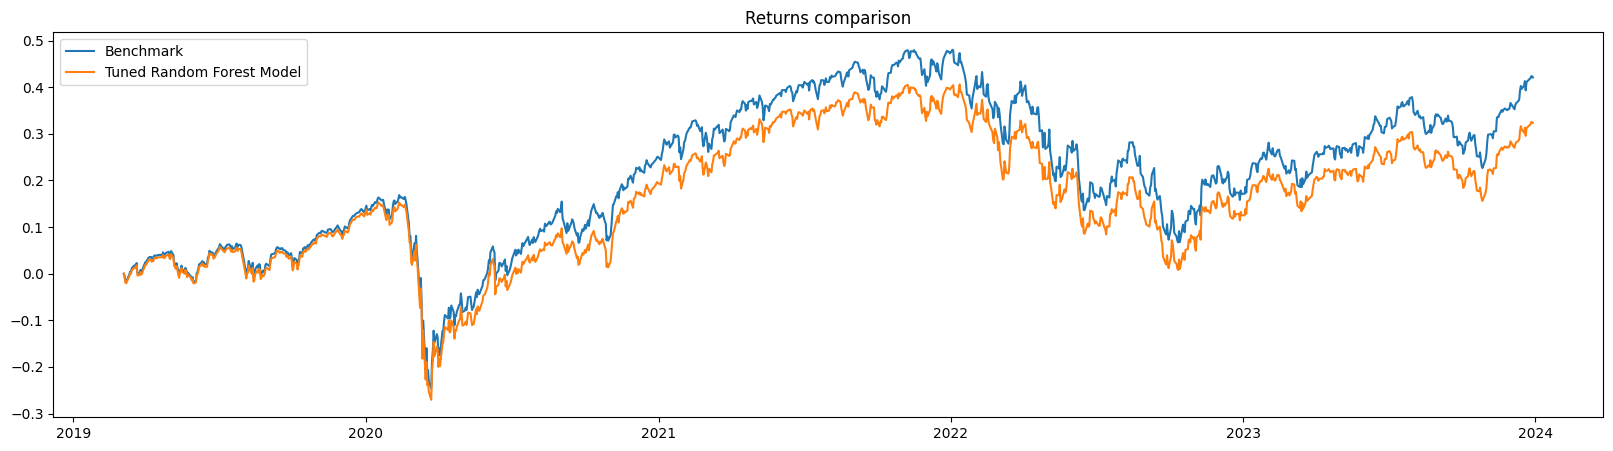

,Annual Returns,Annual Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown,Max Time Under Water,Calmar Ratio,Information Ratio
Benchmark,0.076754,0.203326,0.377494,0.442047,-0.354829,500.0,0.216313,0
Tuned Random Forest Model,0.060545,0.202289,0.299297,0.347409,-0.367138,493.0,0.16491,-0.629015


In [9]:
from helper_functions import run_full_backtesting

models = {'Tuned Random Forest Model': best_model}
df_results = run_full_backtesting(data_provider, x_test, models)
df_results